# DS5220 Homework-04: KAVANA VENKATESH

---

## 3) Implementing Feed Forward Neural Network using PyTorch.

For this exercise, you can use PyTorch using which building and training neural networks are more convenient. You can also use Python to fully implement the neural network (it would be much harder). Implement a Feed Forward Neural Net-work with n layers using either PyTorch, that takes as input the number of layers n and the number of nodes in each layer,S`for`∈ {1,...,n}.  The network must receive a dataset{xi,yi}Ni=1,and must output all the learned weights and biasses of all layers as well as the activations of the last layer. The code must allow specifying the following activation functions: sigmoid, hyperbolic tangent, rectifier linear and identity activation. The loss function must be the cross-entropy loss.

## Importing the Libraries

In [1]:
import torch
import torch.nn as nn
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

## Building the NN Model

In [2]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, n_layers, nodes, activation_list):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.n_layers  = n_layers
        self.nodes = nodes
        self.activation_list = activation_list
        
        self.activation_map = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'identity': nn.Identity(),
                          'sigmoid': nn.Sigmoid()}
        
        #Defining the first layer
        self.hidden_layer = OrderedDict()
        self.hidden_layer['hidden_0a'] = nn.Linear(self.input_size, self.nodes[0])
        self.hidden_layer['hidden_0b']= self.activation_map[self.activation_list[0]]
        
        # Appending all the hidden layers to the list of first layer
        for idx in range(1, n_layers):
            self.hidden_layer['hidden_%sa'%idx] = nn.Linear(self.nodes[idx-1], self.nodes[idx])
            self.hidden_layer['hidden_%sb'%idx] = self.activation_map[self.activation_list[idx]]
        
        self.hidden_layer = nn.Sequential(self.hidden_layer)
        
        self.output_layer = nn.Linear(self.nodes[-1], 2)
        self.output_activation = self.activation_map[self.activation_list[-1]]
        
        
    def forward(self, x):
        
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        
        return x


---

## 4) Training the Model using the given Dataset

1.  Download the dataset of HW04.  Plot the two-dimensional data in the training set.  Use the training labels (-1 and +1) to plot data in different classes with different colors and markers. Are the data linearly separable?

### Loading the Dataset

In [3]:
data = sio.loadmat("C:/Users/kava2/Downloads/hw04_data")
X_train = data['X_trn']
X_test = data['X_tst']
y_train = data['y_trn']
y_test = data['y_tst']

### Converting numpy arrays into tensors

In [4]:
X_train, y_train, X_test, y_test = map(torch.tensor, (X_train, y_train, X_test, y_test))
print(X_train.shape, y_train.shape)

X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

# Converting the labels with value -1 to 0 to make it work for cross entropy loss
mask = y_train[:,0]== -1
y_train[mask, 0] = 0 

mask = y_test[:,0]== -1
y_test[mask, 0] = 0 

torch.Size([1000, 2]) torch.Size([1000, 1])


### Visualize the Dataset

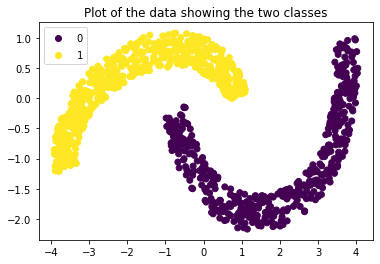

In [5]:
#visualize the data

scatter= plt.scatter(X_train[:,0], X_train[:,1], c=np.squeeze(y_train))
plt.title("Plot of the data showing the two classes")
plt.legend(*scatter.legend_elements())
plt.show()

No. The data is not linearly separable.

---

#### 2) 
Run the NN code (with one hidden layer and with two hidden layers) on the training datasetand evaluate on the test dataset.  Here, you need to explore the effect of different number ofneurons in the hidden layer(s).  Report classification error on the training set and on the testset, when using 10, 30 and 50 neurons in the hidden layer(s).  Plot the data (use differentcolors for data in different classes) and plot the classification results (points predicted to bein class+1with circles and points predicted to be in class −1 with squares).

### Helper Functions to train and test the Model

In [6]:
#Defining function to train and test the model


def classification_error(pred, y):
    correct = 0.0
    with torch.no_grad():
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        
    accuracy = correct/y.size(0)
    error = y.size(0) - correct
    
    return accuracy, error
 

def do_train_epoch(model, x, y, criterion, optimizer):
    model.train()
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    
    optimizer.zero_grad()
    
    pred = model(x)
    y = y.reshape(-1).long()
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    
    accuracy, error = classification_error(pred.clone().detach(), y)
    
    return loss.item(), accuracy, error
    
    
def do_eval_epoch(model, x, y, criterion):
    model.eval()
    
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    
    pred = model(x)
    y = y.reshape(-1).long()
    loss = criterion(pred, y)
    accuracy, error = classification_error(pred.clone().detach(), y)
    
    return loss.item(), accuracy, error


def run_model(model, X_train, y_train, X_test, y_test):
    np.random.seed(0)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    losses, accs, errors = [], [], []
    epoch_no = 4000
    for epoch in range(epoch_no):
        tr_loss, tr_acc, tr_error = do_train_epoch(model, X_train, y_train, criterion, optimizer)
        te_loss, te_acc, te_error = do_eval_epoch(model, X_test, y_test, criterion)

        losses.append([tr_loss, te_loss])
        accs.append([tr_acc, te_acc])
        errors.append([tr_error, te_error])
        
    return losses, accs, errors


## Testing the model for different number of hidden layers and neurons

### a) 1 Hidden Layer with 10 neurons

In [7]:
# Defining parameters and creating an object of the model
                                  
n_layers = 1
nodes = [10]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
print(f"Train and test classification error respectively: {errors[-1]}")
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Train and test classification error respectively: [7.0, 13.0]
Weights of the output layer : Parameter containing:
tensor([[-0.3385,  0.2467,  1.2771, -0.8089, -1.4455,  1.1709, -1.4301, -0.7640,
          1.3521, -0.1438],
        [ 0.5197,  0.0815, -1.3450,  0.7078,  1.5420, -1.2969,  1.1962,  0.8252,
         -1.2590,  0.0949]], requires_grad=True)
Weights of the output layer : Parameter containing:
tensor([-0.1457,  0.1591], requires_grad=True)


**Observation:** With 1 hidden layer and 10 neurons, we have 7 points misclassified for training data and 13 for test data.

[]

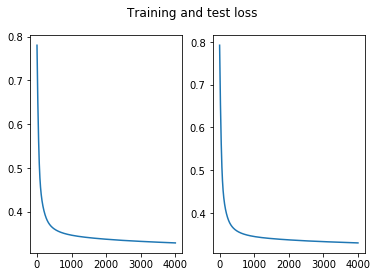

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training and test loss')
ax1.plot([i for i in range(len(losses))],[i[0] for i in losses])
ax2.plot([i for i in range(len(losses))],[i[1] for i in losses])

plt.plot()

In [9]:
print(f"Train classification error : {errors[-1][0]}")
print(f"Test classification error : {errors[-1][1]} ")

Train classification error : 7.0
Test classification error : 13.0 


In [10]:
pred = model(X_train)
correct = 0
_, predicted = torch.max(pred, 1)
y = y_train.reshape(-1).long()
correct += (predicted == y).sum().item()
        
accuracy = correct/y.size(0)
accuracy  


0.993

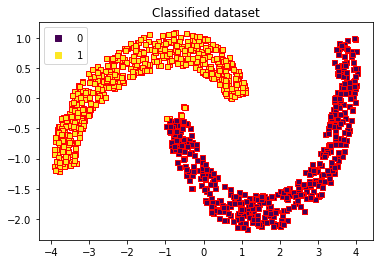

In [11]:
plt.title("Classified dataset")
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], marker='s', c=predicted, s=25, edgecolor='r')
plt.legend(*scatter.legend_elements())
plt.show()

In [12]:
pred = model(X_test)
correct = 0
_, predicted_test = torch.max(pred, 1)

y_test = y_test.reshape(-1).long()
correct += (predicted_test == y_test).sum().item()
        
accuracy = correct/y_test.size(0)
accuracy 


0.987

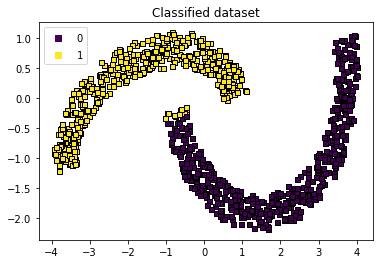

In [13]:
plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='s', c=predicted_test, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

### b) 1 Hidden Layer with 30 neurons

In [14]:
n_layers = 1
nodes = [30]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train.float(), y_train.float(), X_test.float(), y_test.float())
print(f"Train and test classification error respectively: {errors[-1]}")

Train and test classification error respectively: [3.0, 3.0]


In [15]:
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Weights of the output layer : Parameter containing:
tensor([[-2.3583e-01,  5.5886e-01, -1.4307e-01, -5.9656e-01,  3.4166e-01,
          2.1712e-01,  5.4569e-02, -1.3796e+00, -2.3108e-01, -2.6213e-01,
         -2.7925e-01,  1.0077e+00,  7.0969e-01, -4.1348e-01,  6.7184e-01,
         -4.4164e-01,  4.7083e-01, -3.4537e-01,  9.8265e-02,  1.0982e+00,
         -5.5945e-01,  4.2866e-01,  9.8934e-02, -8.0133e-01,  4.0422e-01,
         -8.1912e-01, -8.6996e-01,  9.1555e-01, -1.1449e-01,  6.7496e-01],
        [ 1.3976e-01, -4.9802e-01,  1.1475e-01,  3.8000e-01, -9.5472e-04,
         -2.8507e-01,  2.0786e-01,  1.3166e+00,  1.2443e-01,  3.8506e-01,
          3.7706e-01, -9.0774e-01, -6.7719e-01,  2.3716e-01, -7.1825e-01,
          5.0638e-01, -7.2670e-01,  4.7481e-01, -8.9192e-02, -1.1105e+00,
          5.5033e-01, -4.7178e-01, -8.2682e-02,  8.3109e-01, -3.3589e-01,
          6.2730e-01,  1.0731e+00, -1.0307e+00,  2.3812e-01, -6.0198e-01]],
       requires_grad=True)
Weights of the output layer : 

**Observation:** With 1 hidden layer and 30 neurons, we have 3 points misclassified for training data and 3 for test data which is better than the previous model.

In [16]:
pred = model(X_train)
correct = 0
_, predicted = torch.max(pred, 1)
y = y_train.reshape(-1).long()
correct += (predicted == y).sum().item()
        
accuracy = correct/y.size(0)
accuracy  


0.997

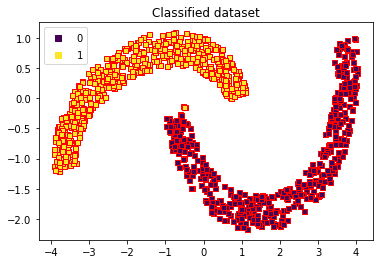

In [17]:
plt.title("Classified dataset")
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], marker='s', c=predicted, s=25, edgecolor='r')
plt.legend(*scatter.legend_elements())
plt.show()

In [18]:
pred = model(X_test)
correct = 0
_, predicted_test = torch.max(pred, 1)

y_test = y_test.reshape(-1).long()
correct += (predicted_test == y_test).sum().item()
        
accuracy = correct/y_test.size(0)
accuracy 


0.997

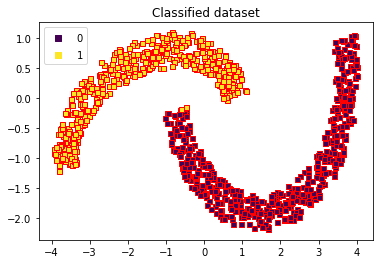

In [19]:
plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='s', c=predicted_test, s=25, edgecolor='r')
plt.legend(*scatter.legend_elements())
plt.show()

### c) 1 Hidden Layer with 50 neurons

In [20]:
n_layers = 1
nodes = [50]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train.float(), y_train.float(), X_test.float(), y_test.float())
print(f"Train and test classification error respectively: {errors[-1]}")

Train and test classification error respectively: [3.0, 2.0]


In [21]:
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Weights of the output layer : Parameter containing:
tensor([[ 0.2586, -0.0728,  0.3067, -0.4041,  0.4872,  0.4426, -0.1770, -0.5208,
         -0.2095,  0.0636, -0.0657, -0.6553, -0.7108, -0.0409,  0.1151, -0.1508,
          0.6130,  0.2680, -0.6828,  0.6010, -0.3802, -0.6446, -0.1723, -0.9009,
         -0.3057, -0.2203,  0.1407,  0.4279,  0.2991,  0.0356, -0.5841, -0.0209,
          1.0315, -0.2405,  0.6673, -0.0913,  0.5851, -0.0749,  0.6472,  0.3416,
          0.3559,  0.5171,  0.6629, -1.0815,  0.5044, -0.0133, -0.2219,  0.4184,
          0.3538,  0.1441],
        [-0.2827, -0.0949, -0.3461,  0.5254, -0.3885, -0.6289, -0.0122,  0.5201,
          0.2974,  0.0297,  0.1466,  0.4951,  0.6413,  0.0417, -0.2075, -0.0703,
         -0.5056, -0.1840,  0.7334, -0.5618,  0.2701,  0.7368,  0.3354,  1.0121,
          0.2513,  0.2904, -0.1217, -0.5162, -0.3266,  0.1839,  0.5090,  0.1512,
         -1.0632,  0.0970, -0.6185,  0.1593, -0.6839,  0.0111, -0.7294, -0.2002,
         -0.1745, -0.6280, -0

**Observation:** With 1 hidden layer and 50 neurons, we have 3 points misclassified for training data and 2 for test data.

In [22]:
pred = model(X_train)
correct = 0
_, predicted = torch.max(pred, 1)
y = y_train.reshape(-1).long()
correct += (predicted == y).sum().item()
        
accuracy = correct/y.size(0)
accuracy  


0.997

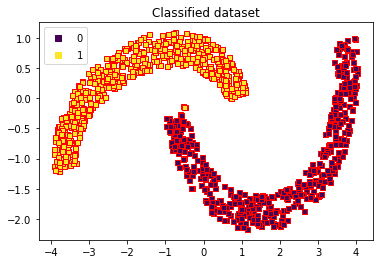

In [23]:
plt.title("Classified dataset")
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], marker='s', c=predicted, s=25, edgecolor='r')
plt.legend(*scatter.legend_elements())
plt.show()

In [24]:
pred = model(X_test)
correct = 0
_, predicted_test = torch.max(pred, 1)

y_test = y_test.reshape(-1).long()
correct += (predicted_test == y_test).sum().item()
        
accuracy = correct/y_test.size(0)
accuracy 


0.998

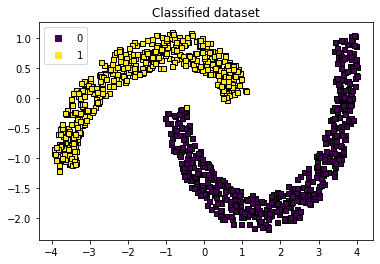

In [25]:
plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='s', c=predicted_test, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

### d)  2 Hidden Layers with 10 and 30 neurons

In [26]:
n_layers = 2
nodes = [10, 30]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train.float(), y_train.float(), X_test.float(), y_test.float())
print(f"Train and test classification error respectively: {errors[-1]}")

Train and test classification error respectively: [1.0, 1.0]


In [27]:
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Weights of the output layer : Parameter containing:
tensor([[-0.2085, -0.6161, -0.6753, -0.9530, -1.3559,  0.4208,  0.0086, -0.3402,
         -0.5321, -1.0303, -1.2492,  0.3165, -0.9428,  0.9025,  0.4528, -0.1368,
          0.1682,  1.0807, -0.6424,  0.6327,  0.9128,  0.0819,  0.4425, -0.6541,
          0.8593, -0.0998,  0.6858,  0.5794,  0.3511,  0.8007],
        [ 0.2940,  0.5985,  0.6780,  1.0938,  1.3315, -0.4989,  0.0685,  0.1239,
          0.7184,  0.9299,  1.1251, -0.1709,  1.0791, -1.0127, -0.4992,  0.1994,
         -0.4377, -1.1536,  0.5700, -0.5054, -0.9488, -0.1850, -0.3359,  0.5504,
         -0.7107,  0.0051, -0.6800, -0.4363, -0.2551, -0.8801]],
       requires_grad=True)
Weights of the output layer : Parameter containing:
tensor([-0.2419,  0.2888], requires_grad=True)


**Observation:** With 2 hidden layers of 10 and 30 neurons, we have 1 point misclassified for training and 1 for test data.

In [28]:
pred = model(X_train)
correct = 0
_, predicted = torch.max(pred, 1)
y = y_train.reshape(-1).long()
correct += (predicted == y).sum().item()
        
accuracy = correct/y.size(0)
accuracy  


0.999

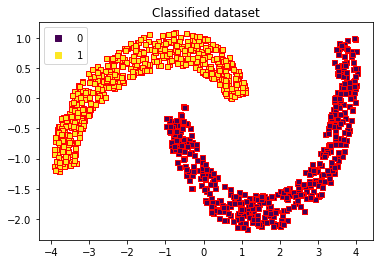

In [29]:
plt.title("Classified dataset")
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], marker='s', c=predicted, s=25, edgecolor='r')
plt.legend(*scatter.legend_elements())
plt.show()

In [30]:
pred = model(X_test)
correct = 0
_, predicted_test = torch.max(pred, 1)

y_test = y_test.reshape(-1).long()
correct += (predicted_test == y_test).sum().item()
        
accuracy = correct/y_test.size(0)
accuracy 


0.999

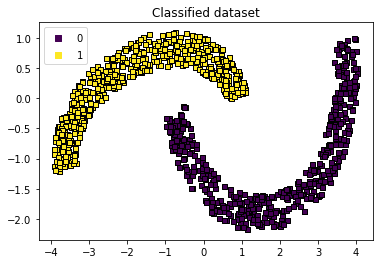

In [31]:
plt.title("Classified dataset")
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], marker='s', c=predicted, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

### e) 2 Hidden Layers with 30 and 50 neurons

In [32]:
n_layers = 2
nodes = [30, 50]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train.float(), y_train.float(), X_test.float(), y_test.float())
print(f"Train and test classification error respectively: {errors[-1]}")

Train and test classification error respectively: [3.0, 1.0]


In [33]:
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Weights of the output layer : Parameter containing:
tensor([[-0.5153,  0.7273, -0.8103, -0.4340,  0.7478, -0.2330,  0.4446, -0.6101,
         -0.3400,  0.3370,  0.3440,  0.7191, -0.2209,  0.2577, -0.2980, -0.6129,
         -0.3136, -0.1828, -0.5930,  0.8905,  0.3278,  0.2240,  0.0905,  0.2812,
          0.1462, -0.5309, -0.0068, -0.8217, -0.3994,  0.3135, -0.4919, -0.1019,
          0.4568,  0.2250,  0.1893,  0.6759,  0.8785, -0.0661,  0.7884, -0.2702,
         -0.6445, -0.0895, -0.0938, -0.5409,  0.0040,  0.4571, -0.6240, -1.1027,
          0.3298, -0.9643],
        [ 0.3027, -0.6227,  0.9091,  0.6544, -0.7514,  0.1632, -0.5893,  0.7149,
          0.2046, -0.3340, -0.3294, -0.5991,  0.2987, -0.4204,  0.4402,  0.5098,
          0.4501,  0.3654,  0.6162, -0.7368, -0.4247, -0.2710, -0.0912, -0.4800,
         -0.1285,  0.6050,  0.0380,  0.6095,  0.4237, -0.1902,  0.4004,  0.0086,
         -0.4837, -0.2654, -0.3549, -0.6959, -0.7606,  0.0998, -0.6538,  0.3049,
          0.7622,  0.1061,  0

**Observation:** With 2 hidden layers of 30 and 50 neurons, 3 points misclassified for training data and 1 for test data.

---

### Plotting the Training Data Classification

In [34]:
pred = model(X_train)
correct = 0
_, predicted = torch.max(pred, 1)
y = y_train.reshape(-1).long()
correct += (predicted == y).sum().item()
        
accuracy = correct/y.size(0)
accuracy  


0.997

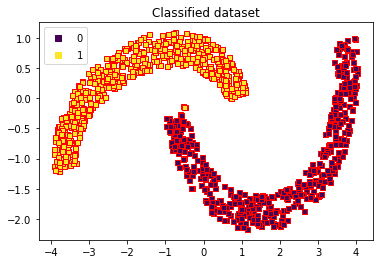

In [35]:
plt.title("Classified dataset")
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], marker='s', c=predicted, s=25, edgecolor='r')
plt.legend(*scatter.legend_elements())
plt.show()

### Plotting the Test Data Classification

In [36]:
pred = model(X_test)
correct = 0
_, predicted_test = torch.max(pred, 1)

y_test = y_test.reshape(-1).long()
correct += (predicted_test == y_test).sum().item()
        
accuracy = correct/y_test.size(0)
accuracy 


0.999

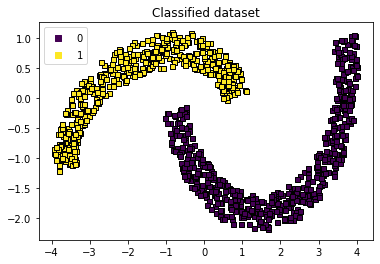

In [37]:
plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='s', c=predicted_test, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()